In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from loguru import logger
from ipynb.fs.defs.Prepare_Data import clean_text

In [3]:
def get_minmax(list_transformed_bboxes):
    x_min = np.inf
    x_max = -np.inf
    y_min = np.inf
    y_max = -np.inf
    z_min = np.inf
    z_max = -np.inf

    for arr in list_transformed_bboxes:
        x_coords = arr[:, 0]
        y_coords = arr[:, 1]
        z_coords = arr[:, 2]
        
        x_min = min(x_min, np.min(x_coords))
        x_max = max(x_max, np.max(x_coords))
        y_min = min(y_min, np.min(y_coords))
        y_max = max(y_max, np.max(y_coords))
        z_min = min(z_min, np.min(z_coords))
        z_max = max(z_max, np.max(z_coords))

    return x_min, x_max, y_min, y_max, z_min, z_max

In [4]:
def transform_boundingbox(x_min, x_max, y_min, y_max, z_min, z_max, ox, oy, oz, xx, xy, xz, yx, yy, yz, zx, zy, zz):
    corners = np.array([[x_min, y_min, z_min],
                        [x_min, y_min, z_max],
                        [x_min, y_max, z_min],
                        [x_min, y_max, z_max],
                        [x_max, y_min, z_min],
                        [x_max, y_min, z_max],
                        [x_max, y_max, z_min],
                        [x_max, y_max, z_max]])
    
    rotation_matrix = np.array([[xx, xy, xz], [yx, yy, yz], [zx, zy, zz]])
    shift_vec = np.array([ox, oy, oz])
    rotated_corners = np.dot(corners, rotation_matrix) 
    transformed_corners = rotated_corners + shift_vec

    return transformed_corners    


In [5]:
def plot_bounding_box(ax, transformed_boundingbox, designation, label_relevant):

    # Define the edges of the bounding box
    edges = [(0, 1), (0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (2, 6), (3, 7), (4, 5), (4, 6), (5, 7), (6, 7)]

    # Plot the edges of the bounding box
    for edge in edges:
        if label_relevant == "Nein":
            ax.plot(transformed_boundingbox[edge, 0], transformed_boundingbox[edge, 1], transformed_boundingbox[edge, 2], color='#999999', alpha=0.5, ms=10)
            relevant_count = 0
        else:
            ax.plot(transformed_boundingbox[edge, 0], transformed_boundingbox[edge, 1], transformed_boundingbox[edge, 2], 'r-')    
            ax.text(transformed_boundingbox[0, 0], transformed_boundingbox[0, 1], transformed_boundingbox[0, 2], designation, color='black', fontsize=10)
    
            relevant_count = 1

    return relevant_count


In [6]:
def plot_vehicle(df: pd.DataFrame, mirrored: bool):
        fig = plt.figure(figsize=(10, 20), dpi=100)

        ax = fig.add_subplot(111, projection='3d')

        # Iterate through the dataframe and plot each bounding box
        count_relevant_parts = 0
        count_all = 0

        for index, row in df.iterrows():    
                transformed_boundingbox = transform_boundingbox(row['X-Min'], row['X-Max'], row['Y-Min'], row['Y-Max'], row['Z-Min'], row['Z-Max'],row['ox'],row['oy'],row['oz'],row['xx'],row['xy'],row['xz'],row['yx'],row['yy'],row['yz'],row['zx'],row['zy'],row['zz'])
                relevant = plot_bounding_box(ax, transformed_boundingbox, row['Benennung (dt)'], row["Relevant fuer Messung"])
                count_relevant_parts = count_relevant_parts + relevant
                count_all = count_all + 1

        print(f"{count_relevant_parts} relevant parts found")
        print(f"Still {count_all-count_relevant_parts} not relevant parts found")

        # Set axis labels
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        
        ax.set_aspect('equal', adjustable='box')

        if mirrored:
                ax.invert_xaxis()

        plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
        plt.savefig("../plots/bounding_boxes/bounding_box_step3.png", format='png', bbox_inches='tight', pad_inches=0)

        # Show the plot
        plt.show()    

In [7]:
def calculate_center_point(transf_bbox):
    sum_X = 0
    sum_Y = 0
    sum_Z = 0
    num_corners = len(transf_bbox)
    for xyz in transf_bbox:
        sum_X = sum_X + xyz[0]
        sum_Y = sum_Y + xyz[1]
        sum_Z = sum_Z + xyz[2]
    
    center_x = sum_X/num_corners
    center_y = sum_Y/num_corners
    center_z = sum_Z/num_corners

    return center_x, center_y, center_z



In [8]:
def calculate_lwh(transformed_boundingbox):
    x = []
    y = []
    z = []

    for xyz in transformed_boundingbox:
        x.append(xyz[0])  
        y.append(xyz[1])  
        z.append(xyz[2])   

    length = max(x) - min(x) 
    width = max(y) - min(y) 
    height = max(z) - min(z) 
    
    return length, width, height

In [9]:
def calculate_orientation(transformed_boundingbox):
    # Center the corners around the origin
    centered_corners = transformed_boundingbox - np.mean(transformed_boundingbox, axis=0) 

    # Perform SVD on the centered corners
    u, s, principal_axes = np.linalg.svd(centered_corners)

    # Convert the principal axes to Euler angles
    theta_x = np.arctan2(principal_axes[2, 1], principal_axes[2, 2])
    theta_y = np.arctan2(-principal_axes[2, 0], np.sqrt(principal_axes[2, 1]**2 + principal_axes[2, 2]**2))
    theta_z = np.arctan2(principal_axes[1, 0], principal_axes[0, 0])

    return theta_x, theta_y, theta_z

In [10]:
def add_new_features(df):
    list_transformed_boundingboxes = []
    for index, row in df.iterrows():  
        # Calculate and add new features to represent the bounding boxes
        transformed_boundingbox = transform_boundingbox(row['X-Min'], row['X-Max'], row['Y-Min'], row['Y-Max'], row['Z-Min'], row['Z-Max'],row['ox'],row['oy'],row['oz'],row['xx'],row['xy'],row['xz'],row['yx'],row['yy'],row['yz'],row['zx'],row['zy'],row['zz'])
        list_transformed_boundingboxes.append(transformed_boundingbox)
        center_x, center_y, center_z = calculate_center_point(transformed_boundingbox)
        length, width, height = calculate_lwh(transformed_boundingbox)
        theta_x, theta_y, theta_z = calculate_orientation(transformed_boundingbox)

        x_coords = transformed_boundingbox[:, 0]
        y_coords = transformed_boundingbox[:, 1]
        z_coords = transformed_boundingbox[:, 2]

        df.at[index, 'X-Min_transf'] = min(x_coords)
        df.at[index, 'X-Max_transf'] = max(x_coords)
        df.at[index, 'Y-Min_transf'] = min(y_coords)
        df.at[index, 'Y-Max_transf'] = max(y_coords)
        df.at[index, 'Z-Min_transf'] = min(z_coords)
        df.at[index, 'Z-Max_transf'] = max(z_coords)   
        df.at[index, 'center_x'] = center_x
        df.at[index, 'center_y'] = center_y
        df.at[index, 'center_z'] = center_z
        df.at[index, 'length'] = length
        df.at[index, 'width'] = width
        df.at[index, 'height'] = height
        df.at[index, 'theta_x'] = theta_x
        df.at[index, 'theta_y'] = theta_y
        df.at[index, 'theta_z'] = theta_z

        # Calculate and add the volume as new feature 
        volume = length * width * height
        df.at[index, 'volume'] = volume

        # If weight is availabe, calculate and add the density as new feature 
        if pd.notnull(row['Wert']) and volume != 0:
            density = row['Wert'] / volume
            df.at[index, 'density'] = density
        
    return df

In [11]:
def check_condition(row, x_min, x_max):
    transformed_boundingbox = transform_boundingbox(row['X-Min'], row['X-Max'], row['Y-Min'], row['Y-Max'], row['Z-Min'], row['Z-Max'],row['ox'],row['oy'],row['oz'],row['xx'],row['xy'],row['xz'],row['yx'],row['yy'],row['yz'],row['zx'],row['zy'],row['zz'])
    
    return min(transformed_boundingbox[:,0]) > (x_min+((x_max-x_min)*0.3))

In [12]:
def preprocess_dataset(df, cut_percent_of_front: float):
    logger.info(f"Start preprocessing the dataframe with {df.shape[0]} samples...")

    df_new_features = add_new_features(df)

    # Using dictionary to convert specific columns
    convert_dict = {'X-Min': float,
                    'X-Max': float,
                    'Y-Min': float,
                    'Y-Max': float,
                    'Z-Min': float,
                    'Z-Max': float,
                    'Wert': float,
                    'ox': float,
                    'oy': float,
                    'oz': float,
                    'xx': float,
                    'xy': float,
                    'xz': float,
                    'yx': float,
                    'yy': float,
                    'yz': float,
                    'zx': float,
                    'zy': float,
                    'zz': float                     
                    }
    
    df_new_features = df_new_features.astype(convert_dict)

    df_new_features = df_new_features[(df_new_features['X-Max'] != 10000) & (df_new_features['X-Max'] != 0)]

    # Save the samples without/wrong bounding box information in a new df, as they will need to be added back later
    df_temp = df[(df["X-Max"] == 10000.0) | (df["X-Max"] == 0.0)]

    # Delete all samples which have less volume than 2,200,000 mm^3 or more then 800,000,000
    df_relevants = df_new_features[(df_new_features['volume'] > 500000)].reset_index(drop=True)

    # Delete all samples where the parts are in the front area of the car
    x_min_transf, x_max_transf = df_relevants["X-Min_transf"].min(), df_relevants["X-Max_transf"].max()
    car_length = x_max_transf - x_min_transf
    cut_point_x = x_min_transf + car_length*cut_percent_of_front
    df_relevants = df_relevants[df_relevants["X-Min_transf"] > cut_point_x]

    df_for_plot = df_relevants.reset_index(drop=True)

    # Concatenate the two data frames vertically
    df_relevants = pd.concat([df_relevants, df_temp]).reset_index(drop=True)

    df_relevants = clean_text(df_relevants)

    # Drop the mirrored car parts (on the right sight) which have the same Sachnummer
    df_relevants = df_relevants[~((df_relevants['Sachnummer'].duplicated(keep='last')) & (df_relevants['yy'] == -1))]

    # Drop the mirrored car parts (on the right sight) which have not the same Sachnummer 
    df_relevants = df_relevants.loc[~(df_relevants.duplicated(subset='Kurzname', keep=False) & (df_relevants['L/R-Kz.'] == 'R'))]

    #df_relevants.drop_duplicates(subset='Sachnummer', inplace=True)

    # Reset the index of the merged data frame
    df_relevants = df_relevants.reset_index(drop=True)

    logger.success(f"The dataset is successfully preprocessed. The new dataset contains {df_relevants.shape[0]} samples")

    return df_relevants, df_for_plot

# Main

In [13]:
df = pd.read_excel("../data/labeled_data/NA7_labeled.xlsx",index_col=0) 

In [22]:
df_preprocessed, df_for_plot = preprocess_dataset(df, cut_percent_of_front=0.20)

2023-05-24 13:19:20.342 | INFO     | __main__:preprocess_dataset:2 - Start preprocessing the dataframe with 2394 samples...
2023-05-24 13:19:21.983 | SUCCESS  | __main__:preprocess_dataset:62 - The dataset is successfully preprocessed. The new dataset contains 548 samples


In [15]:
df.to_excel("test_df.xlsx")

23 relevant parts found
Still 755 not relevant parts found


FileNotFoundError: [Errno 2] No such file or directory: '../plots/bounding_boxes/bounding_box_step3.png'

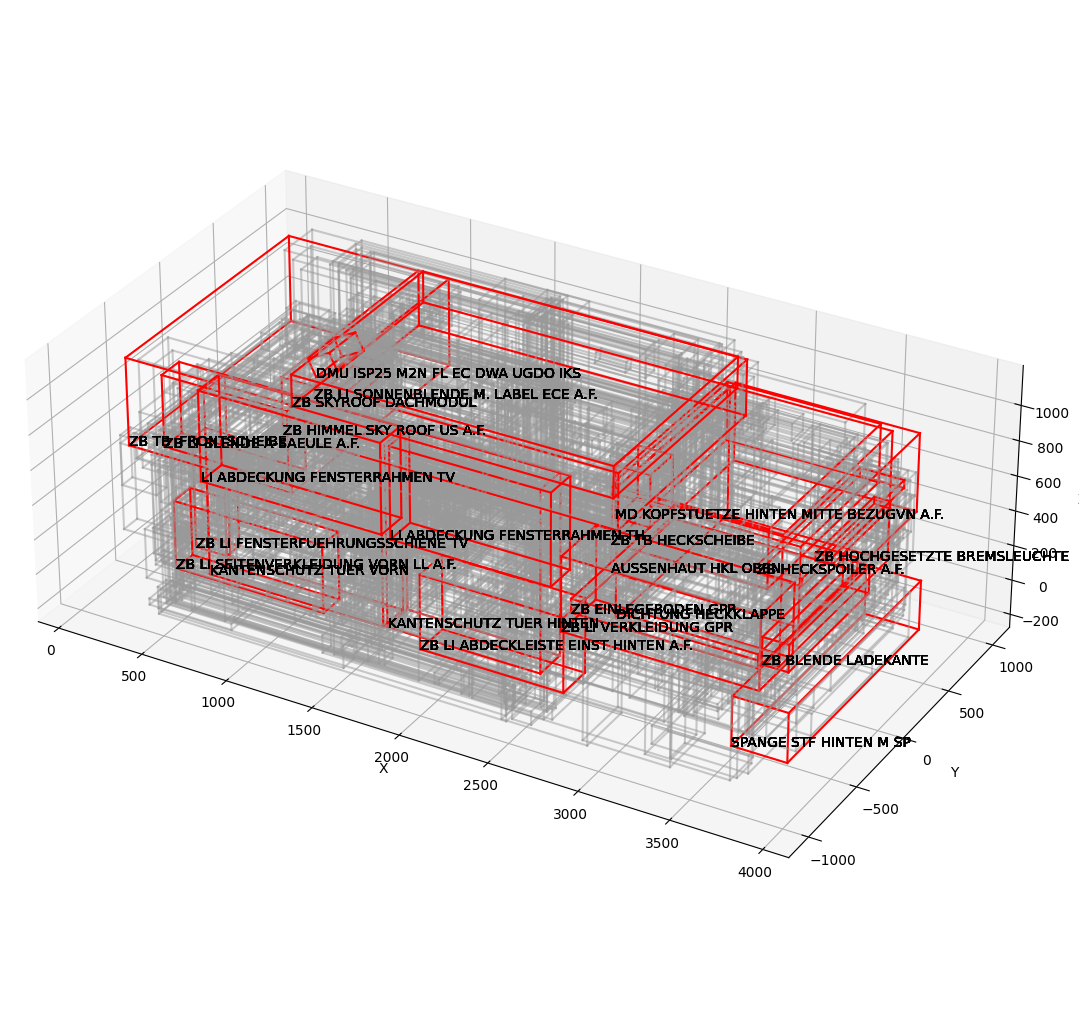

In [19]:
plot_vehicle(df_for_plot, mirrored=False)